[View in Colaboratory](https://colab.research.google.com/github/rdenadai/TxtP-Study-Notebooks/blob/master/notebooks/text_classification_example.ipynb)

## Análise e Validação de Textos em Português


### Referências:

 - Bibliotecas:
  - [NLTK](http://www.nltk.org/howto/portuguese_en.html)
  - [spaCy](https://spacy.io/usage/spacy-101)
  - [Cython](http://cython.org/)
 
 - Dados:
  - [Frases para Face](https://www.frasesparaface.com.br/outras-frases/)
  - [Dicionário Criativo](https://dicionariocriativo.com.br/)
 
 - Tutoriais
  - [Utilizando processamento de linguagem natural para criar uma sumarização automática de textos](https://medium.com/@viniljf/utilizando-processamento-de-linguagem-natural-para-criar-um-sumariza%C3%A7%C3%A3o-autom%C3%A1tica-de-textos-775cb428c84e)
  - [Latent Semantic Analysis (LSA) for Text Classification Tutorial](http://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/)
  - [Machine Learning :: Cosine Similarity for Vector Space Models (Part III)](http://blog.christianperone.com/2013/09/machine-learning-cosine-similarity-for-vector-space-models-part-iii/)
  - [My Notes for Singular Value Decomposition with Interactive Code ](https://towardsdatascience.com/my-notes-for-singular-value-decomposition-with-interactive-code-feat-peter-mills-7584f4f2930a)
  - [https://plot.ly/ipython-notebooks/principal-component-analysis/](https://plot.ly/ipython-notebooks/principal-component-analysis/)
 
 - Topic Modelling
  - [Topic Modeling with LSA, PLSA, LDA & lda2Vec](https://medium.com/nanonets/topic-modeling-with-lsa-psla-lda-and-lda2vec-555ff65b0b05)
  - [Integrating Topics and Syntax (HHM-LDA)](http://psiexp.ss.uci.edu/research/papers/composite.pdf)
 
 - Others
  - [PANAS-t: A Pychometric Scale for Measuring Sentiments on Twitter](https://arxiv.org/abs/1308.1857)
  - [Um Método de Identificação de Emoções em Textos Curtos para o Português do Brasil](http://www.ppgia.pucpr.br/~paraiso/Projects/Emocoes/Emocoes.html)
  - [An Introduction to Latent Semantic Analysis](http://lsa.colorado.edu/papers/dp1.LSAintro.pdf)
  - [Unsupervised Emotion Detection from Text using Semantic and Syntactic Relations](http://www.cse.yorku.ca/~aan/research/paper/Emo_WI10.pdf)
  - [An Efficient Method for Document Categorization Based on Word2vec and Latent Semantic Analysis](https://ieeexplore.ieee.org/document/7363382)
  - [Sentiment Classification of Documents Based on Latent Semantic Analysis](https://link.springer.com/chapter/10.1007/978-3-642-21802-6_57)
  - [Applying latent semantic analysis to classify emotions in Thai text](https://ieeexplore.ieee.org/document/5486137)
  - [Text Emotion Classification Research Based on Improved Latent Semantic Analysis Algorithm](https://www.researchgate.net/publication/266651993_Text_Emotion_Classification_Research_Based_on_Improved_Latent_Semantic_Analysis_Algorithm)

 - Emotions
   - [Basic Emotions](http://changingminds.org/explanations/emotions/basic%20emotions.htm)


### Instalação

In [1]:
!pip install -U spacy Cython
!python -m spacy download en
!python -m spacy download pt
# !pip install feedparser

Requirement already up-to-date: spacy in /usr/local/lib/python3.6/dist-packages (2.0.12)
    100% |████████████████████████████████| 3.4MB 6.5MB/s 
    100% |████████████████████████████████| 37.4MB 63.5MB/s 
  Running setup.py install for en-core-web-sm ... - \ | / - done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/en_core_web_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/en

    You can now load the model via spacy.load('en')

    100% |████████████████████████████████| 38.7MB 66.0MB/s 
  Running setup.py install for pt-core-news-sm ... - \ done

    Linking successful
    /usr/local/lib/python3.6/dist-packages/pt_core_news_sm -->
    /usr/local/lib/python3.6/dist-packages/spacy/data/pt

    You can now load the model via spacy.load('pt')



In [2]:
# Download Oplexicon
!rm -rf wget-log*
!rm -rf oplexicon_v3.0
!wget -O oplexicon_v3.0.zip https://github.com/rdenadai/sentiment-analysis-2018-president-election/blob/master/dataset/oplexicon_v3.0.zip?raw=true
!unzip oplexicon_v3.0.zip
!ls -lh

--2018-10-13 19:28:25--  https://github.com/rdenadai/sentiment-analysis-2018-president-election/blob/master/dataset/oplexicon_v3.0.zip?raw=true
Resolving github.com (github.com)... 192.30.253.112, 192.30.253.113
Connecting to github.com (github.com)|192.30.253.112|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/rdenadai/sentiment-analysis-2018-president-election/raw/master/dataset/oplexicon_v3.0.zip [following]
--2018-10-13 19:28:25--  https://github.com/rdenadai/sentiment-analysis-2018-president-election/raw/master/dataset/oplexicon_v3.0.zip
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/rdenadai/sentiment-analysis-2018-president-election/master/dataset/oplexicon_v3.0.zip [following]
--2018-10-13 19:28:25--  https://raw.githubusercontent.com/rdenadai/sentiment-analysis-2018-president-election/master/dataset/oplexicon_v3.0.zip
Resolving raw.git

### Imports

In [0]:
%load_ext Cython

In [4]:
import nltk

nltk.download('rslp')
nltk.download('averaged_perceptron_tagger')
nltk.download('floresta')
nltk.download('mac_morpho')
nltk.download('machado')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

import concurrent.futures
import codecs
import re
import pprint
from random import shuffle, choices
from string import punctuation
import copy
from unicodedata import normalize

import numpy as np
from scipy.sparse.linalg import svds
from scipy.linalg import svd
import pandas as pd
import spacy
from spacy.lang.pt.lemmatizer import LOOKUP

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics.pairwise import cosine_similarity, cosine_distances
from sklearn.utils.extmath import randomized_svd

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import sent_tokenize
from nltk.corpus import floresta as flt
from nltk.corpus import machado as mch
from nltk.corpus import mac_morpho as mcm

import matplotlib.pyplot as plt

%matplotlib inline

nlp = spacy.load('pt')
pp = pprint.PrettyPrinter(indent=4)
stemmer = nltk.stem.RSLPStemmer()

[nltk_data] Downloading package rslp to /root/nltk_data...
[nltk_data]   Unzipping stemmers/rslp.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package floresta to /root/nltk_data...
[nltk_data]   Unzipping corpora/floresta.zip.
[nltk_data] Downloading package mac_morpho to /root/nltk_data...
[nltk_data]   Unzipping corpora/mac_morpho.zip.
[nltk_data] Downloading package machado to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


### Functions

In [0]:
def normalization(x, a, b):
    return (2 * b) * (x - np.min(x)) / np.ptp(x) + a

def normalization_01(x):
    return (x - np.min(x)) / (np.max(x) - np.min(x))


def remover_acentos(txt):
    return normalize('NFKD', txt).encode('ASCII', 'ignore').decode('ASCII')


def load_oplexicon_data(filename):
    spacy_conv = {
        'adj': 'ADJ',
        'n': 'NOUN',
        'vb': 'VERB',
        'det': 'DET',
        'emot': 'EMOT',
        'htag': 'HTAG'
    }
    
    data = {}
    with codecs.open(filename, 'r', 'UTF-8') as hf:
        lines = hf.readlines()
        for line in lines:
            info = line.lower().split(',')
            if len(info[0].split()) <= 1:
                info[1] = [spacy_conv.get(tag) for tag in info[1].split()]
                word, tags, sent = info[:3]
                if 'HTAG' not in tags and 'EMOT' not in tags:
                    word = remover_acentos(word.replace('-se', ''))
                    word = LOOKUP.get(word, word)
                    # stem = stemmer.stem(word)
                    if word in data:
                        data[word] += [{
                            'word': [word],
                            'tags': tags,
                            'sentiment': sent
                        }]
                    else:
                        data[word] = [{
                            'word': [word],
                            'tags': tags,
                            'sentiment': sent
                        }]
    return data

### Usage

In [6]:
print(LOOKUP.get('Gostaria'.lower(), None))
print(LOOKUP.get('informações'.lower(), None))
print(LOOKUP.get('excelente', None))

frase = u"Gostaria de saber mais informações sobre a Amazon. Uma excelente loja de produtos online!".lower()
doc = nlp(remover_acentos(frase))
pp.pprint([(w.text, w.pos_, w.lemma_) for w in doc])
pp.pprint([stemmer.stem(palavra) for palavra in word_tokenize(frase)])

gostar
informação
None
[   ('gostaria', 'VERB', 'gostar'),
    ('de', 'ADP', 'de'),
    ('saber', 'VERB', 'saber'),
    ('mais', 'ADV', 'mais'),
    ('informacoes', 'NOUN', 'informacoes'),
    ('sobre', 'ADP', 'sobrar'),
    ('a', 'DET', 'o'),
    ('amazon', 'NOUN', 'amazon'),
    ('.', 'PUNCT', '.'),
    ('uma', 'DET', 'umar'),
    ('excelente', 'ADJ', 'excelente'),
    ('loja', 'NOUN', 'loja'),
    ('de', 'ADP', 'de'),
    ('produtos', 'NOUN', 'produto'),
    ('online', 'ADJ', 'online'),
    ('!', 'PUNCT', '!')]
[   'gost',
    'de',
    'sab',
    'mais',
    'inform',
    'sobr',
    'a',
    'amazon',
    '.',
    'uma',
    'excel',
    'loj',
    'de',
    'produt',
    'onlin',
    '!']


In [7]:
opx = load_oplexicon_data('oplexicon_v3.0/lexico_v3.0.txt')
print('Oplexicon size: ', len(opx))
print('Examples: ')

view = opx.items()
pp.pprint(list(view)[:7])

Oplexicon size:  15958
Examples: 
[   ('ab-rogar', [{'sentiment': '-1', 'tags': ['VERB'], 'word': ['ab-rogar']}]),
    ('ababadar', [{'sentiment': '0', 'tags': ['VERB'], 'word': ['ababadar']}]),
    (   'ababelar',
        [   {'sentiment': '-1', 'tags': ['VERB'], 'word': ['ababelar']},
            {'sentiment': '1', 'tags': ['VERB'], 'word': ['ababelar']}]),
    ('abacanar', [{'sentiment': '1', 'tags': ['VERB'], 'word': ['abacanar']}]),
    ('abacinar', [{'sentiment': '1', 'tags': ['VERB'], 'word': ['abacinar']}]),
    (   'abafar',
        [   {'sentiment': '-1', 'tags': ['ADJ'], 'word': ['abafar']},
            {'sentiment': '-1', 'tags': ['ADJ'], 'word': ['abafar']},
            {'sentiment': '-1', 'tags': ['ADJ'], 'word': ['abafar']},
            {'sentiment': '-1', 'tags': ['ADJ'], 'word': ['abafar']},
            {'sentiment': '-1', 'tags': ['VERB'], 'word': ['abafar']}]),
    (   'abafante',
        [   {'sentiment': '-1', 'tags': ['ADJ'], 'word': ['abafante']},
            {'s

In [0]:
ALEGRIA = np.array(list(sorted(set(['abundante', 'acalmar', 'aceitável', 'aclamar', 'aconchego', 'adesão', 'admirar', 'adorar', 'afável', 'afeição', 'afeto', 'afortunado', 'agradar', 'ajeitar', 'alívio', 'amabilidade', 'amado', 'amar', 'amável', 'amenizar', 'ameno', 'amigável', 'amistoso', ' amizade', ' amor', ' animação', ' ânimo', 'anseio', 'ânsia', 'ansioso', 'apaixonado', 'apaziguar', 'aplausos', 'apoiar', 'aprazer', 'apreciar', 'aprovação', 'aproveitar', 'ardor', 'armirar', 'arrumar', 'atração', 'atraente', 'atrair', 'avidamente', 'avidez', 'ávido', 'belo', 'bem-estar', 'beneficência', 'beneficiador', 'benefício', 'benéfico', 'benevocência', 'benignamente', 'benígno', 'bom', 'bondade', 'bondoso', 'bonito', 'brilhante', 'brincadeira', 'calma', 'calor', 'caridade', 'caridoso', 'carinho', 'cativar', 'charme', 'cheery', 'clamar', 'cofortar', 'coleguismo', 'comédia', 'cômico', 'comover', 'compaixão', 'companheirismo', 'compatibilidade', 'compatível', 'complacência', 'completar', 'compreensão', 'conclusão', 'concretização', 'condescendência', 'confiança', 'confortante', 'congratulação', 'conquistar', 'consentir', 'consideração', 'consolação', 'contentamento', 'coragem', 'cordial', 'considerar', 'consolo', 'contente', 'cuidadoso', 'cumplicidade', 'dedicação', 'deleitado', 'delicadamente', 'delicadeza', 'delicado', 'desejar', 'despreocupação', 'devoção', 'devoto', 'diversão', 'divertido', 'encantar', 'elogiado', 'emoção', 'emocionante', 'emotivo', 'empatia', 'empático', 'empolgação', 'enamorar', 'encantado', 'encorajado', 'enfeitar', 'engraçado', 'entendimento', 'entusiasmadamente', 'entusiástico', 'esperança', 'esplendor', 'estima', 'estimar', 'estimulante', 'euforia', 'eufórico', 'euforizante', 'exaltar', 'excelente', 'excitar', 'expansivo', 'extasiar', 'exuberante', 'exultar', 'fã', 'facilitar', 'familiaridade', 'fascinação', 'fascínio', 'favor', 'favorecer', 'favorito', 'felicidade', 'feliz', 'festa', 'festejar', 'festivo', 'fidelidade', 'fiel', 'filantropia', 'filantrópico', 'fraterno', 'ganhar', 'generosidade', 'generoso', 'gentil', 'glória', 'glorificar', 'gostar', 'gostoso', 'gozar', 'gratificante', 'grato', 'hilariante', 'honra', 'humor', 'impressionar', 'incentivar', 'incentivo', 'inclinação', 'incrível', 'inspirar', 'interessar', 'interesse', 'irmandade', 'jovial', 'jubilante', 'júbilo', 'lealdade', 'legítimo', 'leveza', 'louvar', 'louvável', 'louvavelmente', 'lucrativo', 'lucro', 'maravilhoso', 'melhor', 'obter', 'obteve', 'ode', 'orgulho', 'paixão', 'parabenizar', 'paz', 'piedoso', 'positivo', 'prazenteiro', 'prazer', 'predileção', 'preencher', 'preferência', 'preferido', 'promissor', 'prosperidade', 'proteção', 'proteger', 'revigorar', 'simpático', 'vantajoso', 'protetor', 'risada', 'sobrevivência', 'vencedor', 'proveito', 'risonho', 'sobreviver', 'veneração', 'provilégio', 'romântico', 'sorte', 'ventura', 'querer', 'romantismo', 'sortudo', 'vida', 'radiante', 'saciar', 'sucesso', 'vigor', 'realizar', 'saciável', 'surpreender', 'virtude', 'recomendável', 'satisfação', 'tenro', 'virtuoso', 'reconhecer', 'satisfatoriamente', 'ternura', 'vitória', 'recompensa', 'satisfatório', 'torcer', 'vitorioso', 'recrear', 'satisfazer', 'tranquilo', 'viver', 'recreativo', 'satisfeito', 'tranquilo', 'vivo', 'recreação', 'sedução', 'triunfo', 'zelo', 'regozijar', 'seduzir', 'triunfal', 'zeloso', 'respeitar', 'sereno', 'triunfante', 'ressuscitar', 'simpaticamente', 'vantagem',]))))
DESGOSTO = np.array(list(sorted(set(['abominável', 'adoentado', 'amargamente', 'antipatia', 'antipático', 'asco', 'asqueroso', 'aversão', 'chatear', 'chateação', 'desagrado', 'desagradável', 'desprezível', 'detestável', 'doente', 'doença', 'enfermidade', 'enjoativo', 'enjoo', 'enjôo', 'feio', 'fétido', 'golfar', 'grave', 'gravidade', 'grosseiro', 'grosso', 'horrível', 'ignóbil', 'ilegal', 'incomodar', 'incômdo', 'indecente', 'indisposição', 'indisposto', 'inescrupuloso', 'maldade', 'maldoso', 'malvado', 'mau', 'nauseabundo', 'nauseante', 'nausear', 'nauseoso', 'nojento', 'nojo', 'náusea', 'obsceno', 'obstruir', 'obstrução', 'ofensivo', 'patético', 'perigoso', 'repelente', 'repelir', 'repugnante', 'repulsa', 'repulsivo', 'repulsão', 'rude', 'sujeira', 'sujo', 'terrivelmente', 'terrível', 'torpe', 'travesso', 'travessura', 'ultrajante', 'vil', 'vomitar', 'vômito',]))))
MEDO = np.array(list(sorted(set(['abominável', 'afugentar', 'alarmar', 'alerta', 'ameaça', 'amedrontar', 'angustia', 'angústia', 'angustiadamente', 'ansiedade', 'ansioso', 'apavorar', 'apreender', 'apreensão', 'apreensivo', 'arrepio', 'assombrado', 'assombro', 'assustado', 'assustadoramente', 'atemorizar', 'aterrorizante', 'brutal', 'calafrio', 'chocado', 'chocante', 'consternado', 'covarde', 'cruel', 'crueldade', 'cruelmente', 'cuidado', 'cuidadosamente', 'cuidadoso', 'defender', 'defensor', 'defesa', 'derrotar', 'desconfiado', 'desconfiança', 'desencorajar', 'desespero', 'deter', 'envergonhado', 'escandalizado', 'escuridão', 'espantoso', 'estremecedor', 'estremecer', 'expulsar', 'feio', 'friamente', 'fugir', 'hesitar', 'horrendo', 'horripilante', 'horrível', 'horrivelmente', 'horror', 'horrorizar', 'impaciência', 'impaciente', 'impiedade', 'impiedoso', 'indecisão', 'inquieto', 'insegurança', 'inseguro', 'intimidar', 'medonho', 'medroso', 'monstruosamente', 'mortalha', 'nervoso', 'pânico', 'pavor', 'premonição', 'preocupar', 'presságio', 'pressentimento', 'recear', 'receativamente', 'receio', 'receoso', 'ruim', 'suspeita', 'suspense', 'susto', 'temer', 'tenso', 'terror', 'tremor', 'temeroso', 'terrificar', 'timidamente', 'vigiar', 'temor', 'terrível', 'timidez', 'vigilante', 'tensão', 'terrivelmente', 'tímido',]))))
RAIVA = np.array(list(sorted(set(['abominação', 'aborrecer', 'adredido', 'agredir', 'agressão', 'agressivo', 'amaldiçoado', 'amargor', 'amargura', 'amolar', 'angústia', 'animosidade', 'antipatia', 'antipático', 'asco', 'assassinar', 'assassinato', 'assediar', 'assédio', 'atormentar', 'avarento', 'avareza', 'aversão', 'beligerante', 'bravejar', 'chateação', 'chato', 'cobiçoso', 'cólera', 'colérico', 'complicar', 'contraiedade', 'contrariar', 'corrupção', 'corrupto', 'cruxificar', 'demoníaco', 'demônio', 'descaso', 'descontente', 'descontrole', 'desenganar', 'desgostar', 'desgraça', 'desprazer', 'desprezar', 'destruição', 'destruir', 'detestar', 'diabo', 'diabólico', 'doido', 'encolerizar', 'energicamente', 'enfurecido', 'enfuriante', 'enlouquecer', 'enraivecer', 'escandalizar', 'escândalo', 'escoriar', 'exasperar', 'execração', 'ferir', 'frustração', 'frustrar', 'fúria', 'furioso', 'furor', 'ganância', 'ganancioso', 'guerra', 'guerreador', 'guerrilha', 'hostil', 'humilhar', 'implicância', 'implicar', 'importunar', 'incomodar', 'incômodo', 'indignar', 'infernizar', 'inimigo', 'inimizade', 'injúria', 'injuriado', 'injustiça', 'insulto', 'malícia', 'odiável', 'repulsivo', 'inveja', 'malicioso', 'ódio', 'resmungar', 'ira', 'malignidade', 'odioso', 'ressentido', 'irado', 'malígno', 'ofendido', 'revolta', 'irascibilidade', 'maltratar', 'ofensa', 'ridículo', 'irascível', 'maluco', 'opressão', 'tempestuoso', 'irritar', 'malvadeza', 'opressivo', 'tirano', 'louco', 'malvado', 'oprimir', 'tormento', 'loucura', 'matar', 'perseguição', 'torturar', 'magoar', 'mesquinho', 'perseguir', 'ultrage', 'mal', 'misantropia', 'perturbar', 'ultrajar', 'maldade', 'misantrópico', 'perverso', 'vexatório', 'maldição', 'molestar', 'provocar', 'vigoroso', 'maldito', 'moléstia', 'rabugento', 'vingança', 'maldizer', 'mortal', 'raivoso', 'vingar', 'maldoso', 'morte', 'rancor', 'vingativo', 'maleficência', 'mortífero', 'reclamar', 'violência', 'maléfico', 'mortificar', 'repressão', 'violento', 'malevolência', 'nervoso', 'reprimir', 'zangar', 'malévolo', 'odiar', 'repulsa',]))))
SURPRESA = np.array(list(sorted(set(['admirar', 'afeição', 'apavorante', 'assombro', 'chocado', 'chocante', 'desconcertar', 'deslumbrar', 'embasbacar', 'emudecer', 'encantamento', 'enorme', 'espanto', 'estupefante', 'estupefato', 'estupefazer', 'expectativa', 'fantasticamente', 'fantástico', 'horripilante', 'imaginário', 'imenso', 'impressionado', 'incrível', 'maravilha', 'milagre', 'mistério', 'misterioso', 'ótimo', 'pasmo', 'perplexo', 'prodígio', 'sensacional', 'surpreendente', 'surpreender', 'suspense', 'susto', 'temor', 'tremendo',]))))
TRISTEZA = np.array(list(sorted(set(['abandonar', 'abatido', 'abominável', 'aborrecer', 'abortar', 'afligir', 'aflito', 'aflição', 'agoniar', 'amargo', 'amargor', 'amargura', 'ansiedade', 'arrepender', 'arrependidamente', 'atrito', 'azar', 'cabisbaixo', 'choro', 'choroso', 'chorão', 'coitado', 'compassivo', 'compunção', 'contristador', 'contrito', 'contrição', 'culpa', 'defeituoso', 'degradante', 'deplorável', 'deposição', 'depravado', 'depressivo', 'depressão', 'deprimente', 'deprimir', 'derrota', 'derrubar', 'desalentar', 'desamparo', 'desanimar', 'desapontar', 'desconsolo', 'descontente', 'desculpas', 'desencorajar', 'desespero', 'desgaste', 'desgosto', 'desgraça', 'desistir', 'desistência', 'deslocado', 'desmoralizar', 'desolar', 'desonra', 'despojado', 'desprazer', 'desprezo', 'desumano', 'desânimo', 'discriminar', 'disforia', 'disfórico', 'dissuadir', 'doloroso', 'dor', 'dó', 'enfadado', 'enlutar', 'entediado', 'entristecedor', 'entristecer', 'envergonhar', 'errante', 'erro', 'errôneo', 'escurecer', 'escuridão', 'escuro', 'esquecido', 'estragado', 'execrável', 'extirpar', 'falsidade', 'falso', 'falta', 'fraco', 'fraqueza', 'fricção', 'frieza', 'frio', 'funesto', 'fúnebre', 'grave', 'horror', 'humilhar', 'inconsolável', 'indefeso', 'infelicidade', 'infeliz', 'infortúnio', 'isolar', 'lacrimejante', 'lacrimoso', 'lamentar', 'lastimoso', 'luto', 'lutoso', 'lágrima', 'lástima', 'lúgubre', 'magoar', 'martirizar', 'martírio', 'mau', 'melancolia', 'melancólico', 'menosprezar', 'miseravelmente', 'misterioso', 'mistério', 'miséria', 'morre', 'morte', 'mortificante', 'mágoa', 'negligentemente', 'nocivo', 'obscuro', 'opressivo', 'opressão', 'oprimir', 'pena', 'penalizar', 'penitente', 'penoso', 'penumbra', 'perder', 'perturbado', 'perverso', 'pervertar', 'pesaroso', 'pessimamente', 'piedade', 'pobre', 'porcamente', 'prejudicado', 'prejudicial', 'prejuízo', 'pressionar', 'pressão', 'quebrar', 'queda', 'queixoso', 'rechaçar', 'remorso', 'repressivo', 'repressão', 'reprimir', 'ruim', 'secreto', 'servil', 'sobrecarga', 'sobrecarregado', 'sofrer', 'sofrimento', 'solidão', 'sombrio', 'soturno', 'sujo', 'suplicar', 'suplício', 'só', 'timidez', 'torturar', 'trevas', 'triste', 'tristemente', 'tédio', 'tímido', 'vazio',]))))

emotion_words = {
    'ALEGRIA': ALEGRIA,
    'DESGOSTO': DESGOSTO,
    'MEDO': MEDO,
    'RAIVA': RAIVA,
    'SURPRESA': SURPRESA,
    'TRISTEZA': TRISTEZA,
}
for key, values in emotion_words.items():
    for i, word in enumerate(values):
        word = remover_acentos(word.lower()).strip()
        emotion_words[key][i] = LOOKUP.get(word, word)
# pp.pprint(emotion_words)

In [240]:
stpwords = stopwords.words('portuguese') + list(punctuation)
rms = ['um', 'não', 'mais', 'muito']
for rm in rms:
    del stpwords[stpwords.index(rm)]

def is_number(s):
    try:
        complex(s) # for int, long, float and complex
    except ValueError:
        return False
    return True

def tokenize_frases(frase):
    return word_tokenize(remover_acentos(frase.lower()))

def rm_stop_words_tokenized(frase):
    frase = nlp(re.sub(r'["\'@#%\(\)]', '', remover_acentos(frase.lower())))
    clean_frase = []
    for palavra in frase:
        if palavra.pos_ != 'PUNCT':
            word = palavra.text.strip()
            if not is_number(word) and word not in stpwords:
                clean_frase.append(palavra.lemma_)
    return ' '.join(clean_frase)

def generate_corpus(frases, tokenize=False):
    print('Iniciando processamento...')
    tokenized_frases = frases
    with concurrent.futures.ProcessPoolExecutor(max_workers=4) as procs:
        if tokenize:
            print('Executando processo de tokenização das frases...')
            tokenized_frases = procs.map(tokenize_frases, frases, chunksize=25)
        print('Executando processo de remoção das stopwords...')
        tokenized_frases = procs.map(rm_stop_words_tokenized, tokenized_frases, chunksize=25)
    print('Filtro e finalização...')
    return tokenized_frases


frases_originais = [
    # 'Bom dia SENADOR, agora está claro porque o pedágio não baixava,o judiciário não se manifestava quando era provocado e as CPIs só serviram prá corrupção,deu no que deu 🙄',
    # 'Não basta apenas retirar o candidato preferencial da maioria dos eleitores brasileiros. Tem que impedir também que esses mesmos eleitores possam comparecer às urnas. Que democracia é essa, minha gente? Poder judiciário comprometido até os cabelos com o golpe de destrói o país.',
    
    # DIVERSAS
    'Deus abençoe o dia de todos você, tenham um bom trabalho e bom estudo a todos. E pra aqueles que não trabalha e nem estuda, boa curtição em sua cama 🙂',
    'Aprenda a ter amor próprio que nem essa banana que fez uma tatuagem dela mesma.',
    'Estou muito feliz hoje',
    'Dias chuvosos me deixam triste',
    'Hoje o dia esta excelente, eu fico feliz com isso!',
    'Eu fico feliz tomando sorvete',
    'Tem certas coisas que eu não como, acho bem nojento ficar mastigando lingua de boi por exemplo',
    'É de se admirar àqueles que conseguem realizar boas ações sem desejar nada em troca',
    'Só existem dois motivos pra uma pessoa se preocupar com você: Ou ela te ama muito, ou você tem algo que ela queira muito!',
    'Ser feliz nao é ter uma vida perfeita, mas sim reconhecer que vale a pena viver apesar de todos os desafios e perdas.',
    'Minha maravilhosa vida é uma merda.',
    
    # ALEGRE
    'Quando a tristeza bater na sua porta, abra um belo sorriso e diga: Desculpa, mas hoje a felicidade chegou primeiro!',
    'Feliz é aquele que vê a felicidade dos outros sem ter inveja. O sol é para todos e a sombra pra quem merece.',
    'Minha meta é ser feliz, não perfeito.',
    'Ser feliz até onde der, até onde puder. Sem adiar, ser feliz o tanto que durar.',
    'Nunca deixe ninguém dizer que você não pode fazer alguma coisa. Se você tem um sonho, tem que correr atrás dele. As pessoas não conseguem vencer, e dizem que você também não vai vencer. Se quer alguma coisa, corre atrás.',
    'Não se importe com o que vão pensar de você, faça o que você quiser e procure apenas a sua felicidade.',
    'Não estou a fim de lidar com a negatividade, eu já tenho a minha opinião. Eu farei o que me faz feliz.',
    'Ame, grite, cante, sorria, dance, iluda-se, odeie, viva, chore, brinque… Não tenha limites para as ações e atitudes. Seja Feliz, isso basta!',
    'Mergulha no que te dá vontade. Que a vida não espera por ti.',
    'Que a felicidade vire rotina.',
    'Corra atrás da sua própria felicidade, antes que ela corra para longe de você.',
    'Faça o que for necessário para ser feliz. Mas não se esqueça que a felicidade é um sentimento simples, você pode encontrá-la e deixá-la ir embora por não perceber sua simplicidade.',
    'A chave da felicidade é sonhar; a chave do sucesso é tornar os sonhos realidade.'
    'Se quer viver uma vida feliz, amarre-se a uma meta, não às pessoas nem às coisas.',
    'Na incerteza do amanhã, escolhi o hoje para ser feliz.',
    'Tem coisa que dá vontade de viver de novo. E de novo, e de novo...',
    'Lembre-se que a felicidade é um modo de viver e não um objetivo de vida.',
    'Felicidade é saber aproveitar todos os momentos como se fossem os últimos.',
    
#     # ARREPENDIMENTO / TRISTEZA / DESGOSTO
    'O maior problema em acreditar nas pessoas erradas, é que um dia você acaba não acreditando em mais ninguém.',
    'Não me deixe ir, posso nunca mais voltar.',
    'Não me arrependo de ter conhecido ninguém, só me arrependo de ter perdido tanto tempo com algumas pessoas.',
    'Se existe uma coisa que eu me arrependo é de ter confiado em algumas pessoas.',
    'Existem momentos em que as palavras são desnecessárias, apenas o silêncio nos é a resposta.',
    'Prefiro que enxerguem em mim erros com arrependimento do que uma falsa perfeição.',
    'Um momento de paciência em um momento de raiva pode salvar cem dias de arrependimentos.',
    'Você espera que a pessoa amadureça... Ela vai e apodrece.',
    'Pare de ser um prisioneiro do seu passado. Transforme-se no arquiteto do seu futuro!',
    'Pense antes de falar para não se arrepender depois.',
    'Ofensas não conduzem ao bom termo.',
    'Saiba que a dor por perder um amor é mais aguda quando vem junta com o arrependimento.',
    'E às vezes são as escolhas erradas que te levam ao rumo certo.',
    'Todo mundo erra. Nem todo o mundo perdoa.',
    'Daqui a alguns anos você estará mais arrependido pelas coisas que não fez do que pelas que fez, então solte suas amarras, afaste-se do porto seguro, agarre o vento em suas velas,explore, sonhe e descubra.',
    'Os espinhos que colhi, são da árvore que plantei.',
    'O arrependimento é ineficaz quando as reincidências são consecutivas.',
    
#     # LUTO / TRISTEZA
    'Mesmo sabendo que um dia a vida acaba, a gente nunca está preparado para perder alguém.',
    'A morte é uma pétala que se solta da flor e deixa uma eterna saudade no coração.',
    'Mãe é imortal, porque quando ela parte para outro mundo fica vivendo nas lágrimas que escorrem em nosso rosto eternamente.',
    'Ficam as lembranças para contar como foi sua vida e restam as saudades para lembrar a falta que você fará.',
    'Partiu para não mais voltar, e meu coração se partiu para não mais se recompor. Saudades de quem a morte levou para sempre.',
    'Hoje o meu dia amanheceu mais triste, pois lembrei do sorriso de um grande amigo que a vida me tirou sem nenhum aviso.',
    'Só a fé e a certeza que vou te encontrar novamente me dão forças para continuar.',
    'Luto é o tempo necessário para a mente entender o sentimento de perda que o coração já sente.',
    'Avós que se foram deixam nossas vidas mais pobres, mas suas histórias para sempre as enriquecerão.',
    'Quem partiu segue vivendo na minha saudade, e com muito carinho na minha memória.',
    'Meu coração navega sem rumo desde a hora que minha mãe se foi.',
    'Suas memórias são meu maior tesouro. Saudades suas, meu pai!',
    'Meu amigo se foi para sempre. No seu lugar ficaram estas saudades eternas, que eternamente serão sentidas com muita tristeza.',
    'É a esperança de reencontrar você um dia que diminui a dor da saudade que sinto, minha mãe!',
    'Até a dor da perda pode ser aliviada através da paz da oração!',
    'Apesar de sentir saudade dos que já partiram, todos continuam próximos do meu coração.',
    
#     # REFLEXÃO / TRISTEZA / ALEGRIA
    'As montanhas da vida não existem apenas para que você chegue no topo, mas para que você aprenda o valor da escalada.',
    'A vida pode até te derrubar, mas é você quem escolhe a hora de se levantar.',
    'É melhor ser verdadeiro e solitário do que viver em falsidade e estar sempre acompanhado.',
    'Na minha vida até agora, descobri que na verdade só há dois tipos de pessoas: aqueles que estão com você, e aqueles que estão contra você.',
    'Ser feliz nao é ter uma vida perfeita, mas sim reconhecer que vale a pena viver apesar de todos os desafios e perdas.',
    'Aprendi que não devo me importar com comentários que não vão mudar minha vida.',
    'A vida tem sons, que pra gente ouvir precisa aprender a começar de novo.',
    'A vida é basicamente uma montanha russa.',
    'O mundo está nas mãos daqueles que têm a coragem de sonhar e de correr o risco de viver seus sonhos.',
    'Deus sabe quem colocar na sua vida, da mesma forma que sabe quem tirar.',
    'Não viva para que sua presença seja notada, mas para que sua falta seja sentida.',
    'Um novo dia é uma página em branco na sua vida. Escreva apenas o que vale a pena.',
    'A vida é como andar de bicicleta. Para ter equilíbrio, você tem que se manter em movimento...',
    'Viva o hoje, pois o ontem já se foi, e o amanhã talvez não venha.',
    'Não corra atrás de um alguém que demonstra viver bem sem você.',
    
#     # ENGRACADAS / SARCASMO ???
    'Um brinde aos nossos defeitos. Porque com as nossas qualidades ninguém se importa mesmo.',
    'Se quem ama cuida, muita gente deve me amar. Porque o que tem de pessoas cuidando da minha vida, não é brincadeira!',
    'Certas pessoas são como nuvens. Quando somem, o dia fica lindo!',
    'Até a bateria do meu celular dura mais do que o amor eterno de certas pessoas!',
    'Passar o dia sem irritar alguns amigos dá a sensação que o dia não está completo.',
    'Único final feliz que eu conheço é o final de semana.',
    
#     # ATITUDE ???
    'A sua vida só vai pra frente depois que você se desapega das pessoas que te levam pra trás!',
    'Ninguém viveu minha vida. Ninguém chorou minhas lágrimas. Então não julgue, e apenas fique na sua.',
    'Feliz ou não, a lei da vida sempre é seguir em frente com a cabeça erguida.',
    'Nenhum obstáculo será grande, se a sua vontade de vencer for maior!',
    'Seja como o fogo: saiba aquecer quem precisa e queimar quem merece.',
    'O caminho é longo, mas a vitória é certa.',
    'O passado está na tua cabeça. O futuro nas tuas mãos!',
    'Pessoas deveriam ter coragem de assumir seus próprios erros assim como têm orgulho em exibir suas qualidades.',
    'Dê valor aos momentos e não às lembranças, porque o passado nunca volta.',
    'Todos caem, mas apenas os fracos continuam no chão.',
    'Ser uma pessoa melhor, não perfeito, apenas melhor que ontem!',
    'O que você pensa sobre mim não vai mudar quem eu sou, mas pode mudar o meu conceito sobre você.',
    'A vida me ensinou a dizer adeus às pessoas que amo, sem tirá-las do meu coração.',
    'Sinto orgulho do meu coração, ele já foi partido, traído, pisoteado, maltratado e continua funcionando.',
    'Hoje em dia as pessoas sabem o preço de tudo, mas não sabem o valor de nada.',
]

# N = 10000

frases = copy.deepcopy(frases_originais)
# frases += [' '.join(f).replace('_', ' ') for f in flt.sents()[:500]]
# frases += [' '.join(f).replace('_', ' ') for f in mch.sents()[:500]]
# frases += [' '.join(f).replace('_', ' ') for f in mcm.sents()[:500]]

frases = list(generate_corpus(frases, tokenize=False))
# print(frases)

ldocs = [f'D{i}' for i in range(len(frases))]

Iniciando processamento...
Executando processo de remoção das stopwords...
Filtro e finalização...


In [241]:
print('Tf-Idf:')
vec_tfidf = TfidfVectorizer(max_df=5, sublinear_tf=False, use_idf=True, ngram_range=(1, 2))
X_tfidf = vec_tfidf.fit_transform(frases)
print("   Actual number of tfidf features: %d" % X_tfidf.get_shape()[1])
weights_tfidf = pd.DataFrame(np.round(X_tfidf.toarray().T, 3), index=vec_tfidf.get_feature_names(), columns=ldocs)
display(weights_tfidf.head(15))

Tf-Idf:
   Actual number of tfidf features: 1104


,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96
abencoe,0.167,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abencoe dia,0.167,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abrir,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
abrir um,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acabar,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acabar gente,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acabar nao,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
achar,0.000,0.0,0.0,0.0,0.0,0.0,0.24,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
achar bem,0.000,0.0,0.0,0.0,0.0,0.0,0.24,0.000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
acoes,0.000,0.0,0.0,0.0,0.0,0.0,0.00,0.243,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [242]:
print('Count:')
vec_count = CountVectorizer()
X_count = vec_count.fit_transform(frases)
print("   Actual number of tfidf features: %d" % X_count.get_shape()[1])
weights_count = pd.DataFrame(X_count.toarray().T, index=vec_count.get_feature_names(), columns=ldocs)
display(weights_count.head(15))

Count:
   Actual number of tfidf features: 392


,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96
abencoe,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abrir,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acabar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
achar,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acoes,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
acompanhar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
acreditar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
adeus,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
adiar,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
admirar,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0


In [243]:
USE = True
X = X_count if USE else X_tfidf
weights = weights_count if USE else weights_tfidf
vectorizer = vec_count if USE else vec_tfidf

print('SVD: ')
AC = copy.deepcopy(X.toarray().T)
u, s, v = np.linalg.svd(AC, full_matrices=False)
print('Original and SVD equals: ', np.allclose(AC, np.dot(u, np.dot(np.diag(s), v))))

# print(AC)
# print(u.astype(np.float16))
# print('-' * 20)
# print(np.diag(s.astype(np.float16)))
# print('-' * 20)
# print(v.astype(np.float16))

SVD: 
Original and SVD equals:  True


In [244]:
print('Matriz U:')
print(u.shape)
weights_um = pd.DataFrame(u, index=vectorizer.get_feature_names(), columns=ldocs)#.astype(np.float16)
display(weights_um.head(15))

Matriz U:
(392, 97)


,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96
abencoe,-0.016569,-0.015622,0.071081,-0.035224,0.073840,-0.100766,0.016546,-0.008586,0.021425,-0.020539,...,-0.003575,-0.000925,0.013205,-0.009994,-0.005062,-0.000314,0.004639,-0.014244,0.012375,0.005291
abrir,-0.004544,-0.002069,0.013556,-0.018520,0.005262,0.029173,0.012296,-0.004603,-0.023434,-0.008207,...,-0.004288,-0.013660,0.036664,-0.016117,0.005241,0.029120,0.010252,-0.012884,-0.019144,-0.007365
acabar,-0.022230,-0.010243,0.058281,-0.037942,-0.029422,0.043422,0.020509,-0.032574,0.022578,0.019840,...,-0.013622,0.097709,-0.033755,-0.009967,0.009597,0.056534,0.001368,0.029908,0.036633,0.019071
achar,-0.007354,-0.002340,-0.013858,-0.011819,-0.011065,-0.005976,-0.000408,0.006789,0.003820,0.008619,...,0.011608,0.038131,0.012352,0.005049,0.010558,0.007013,0.003918,-0.005390,0.021168,0.002574
acoes,-0.008451,-0.017673,-0.016233,-0.010045,0.013011,-0.016749,-0.008065,0.005237,0.051855,0.011290,...,-0.000778,-0.013257,0.002543,0.003664,0.012962,-0.015993,-0.003418,0.013272,-0.009852,-0.128445
acompanhar,-0.002052,-0.013733,-0.008028,0.005974,0.003942,0.006693,-0.004253,0.001067,-0.019616,0.005588,...,-0.015728,0.020487,-0.030053,0.011742,-0.006897,0.020170,-0.033957,-0.060564,0.029523,0.007604
acreditar,-0.032242,0.004208,0.049399,-0.042919,-0.025648,0.027234,0.000016,-0.062183,0.033247,0.038832,...,-0.118820,-0.041376,0.005615,-0.007195,0.001370,-0.007240,0.017843,-0.008650,0.003279,-0.027696
adeus,-0.005039,-0.004980,0.009689,0.011712,-0.027784,0.005832,0.002829,-0.004962,-0.005213,0.014856,...,0.087213,-0.002352,0.010982,-0.006904,0.026506,-0.012976,-0.026203,-0.051757,0.014121,-0.300863
adiar,-0.005882,-0.035903,-0.029784,0.039177,0.064033,0.053202,-0.008949,-0.068319,-0.004450,-0.011673,...,-0.001379,-0.013866,-0.008587,0.008234,0.008490,-0.010880,0.024224,0.021646,-0.016128,-0.008518
admirar,-0.001170,-0.000481,0.005661,-0.006019,0.009834,-0.014722,0.004565,-0.001478,0.008065,0.001873,...,0.004592,-0.011803,0.008124,-0.000422,0.016548,-0.008062,-0.018864,0.009781,0.000891,0.873463


In [245]:
print('Matriz VT:')
weights_vm = pd.DataFrame(v.T, columns=ldocs)
display(weights_vm.head(15))

Matriz VT:


,D0,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D87,D88,D89,D90,D91,D92,D93,D94,D95,D96
0,-0.177124,-0.106830,0.431801,-0.206530,0.411876,-0.541705,0.086402,-0.042965,0.104422,-0.095538,...,-0.005595,-0.001415,0.019319,-0.014580,-0.007343,-0.000430,0.006137,-0.018641,0.011652,2.217891e-18
1,-0.022396,-0.016509,-0.032854,0.015160,-0.045179,-0.052946,0.085915,-0.073944,0.016097,-0.068998,...,0.001957,0.044902,0.037576,-0.026201,-0.025709,0.019598,0.006405,-0.038794,0.012201,2.254488e-16
2,-0.018186,-0.060858,-0.015254,0.042623,0.024896,0.038367,-0.014684,-0.063484,-0.005374,0.009580,...,-0.084445,0.002171,-0.124973,0.102102,0.023800,-0.175504,-0.170588,0.076613,0.836008,1.151224e-16
3,-0.018662,-0.013137,0.052582,-0.061378,0.001829,0.042834,0.007435,-0.042605,0.008728,0.009445,...,0.420542,-0.410861,0.162773,0.155414,0.129173,0.307688,-0.056917,0.225278,0.093944,1.543452e-16
4,-0.026979,-0.089589,0.028290,-0.023785,0.021133,0.068374,0.013505,-0.086292,-0.002088,0.004007,...,-0.015458,-0.012583,-0.107605,0.109513,0.032010,-0.369357,-0.456877,0.214872,-0.435059,-1.421455e-16
5,-0.014843,-0.063938,-0.034997,0.031198,0.026494,0.026164,-0.010704,-0.030161,-0.025921,-0.000808,...,-0.128536,0.198166,0.161751,-0.143992,-0.084958,0.340842,0.380964,-0.069763,0.039061,-3.322483e-16
6,-0.078621,-0.016004,-0.084181,-0.069301,-0.061718,-0.032127,-0.002129,0.033973,0.018620,0.040093,...,0.018165,0.058342,0.018071,0.007367,0.015315,0.009604,0.005183,-0.007054,0.019932,6.045533e-17
7,-0.012506,-0.003291,0.034390,-0.035290,0.054853,-0.079145,0.023837,-0.007395,0.039306,0.008711,...,0.007186,-0.018058,0.011886,-0.000616,0.024005,-0.011041,-0.024953,0.012800,0.000839,-2.827672e-17
8,-0.141725,0.174128,0.199886,0.338190,-0.025797,-0.078637,-0.084117,-0.156566,-0.030176,0.126754,...,0.079565,0.048207,0.057031,-0.046660,-0.058242,-0.003392,0.027348,0.019628,-0.108925,1.468649e-16
9,-0.134211,-0.378573,-0.090228,0.148900,0.055940,-0.117242,0.125825,0.114068,-0.134898,0.008584,...,0.038652,0.016264,-0.009168,0.000476,0.000496,-0.005562,0.008164,0.018293,-0.001073,-7.071068e-01


In [0]:
%%cython
cimport numpy as np
import numpy as np

def calculate_cython(u, dict idx, dict emotion_words, weights, _ldocs):
    cdef int k
    cdef int i
    cdef list values
    
    wv = np.zeros((_ldocs, len(emotion_words.keys())))
    for k, values in enumerate(emotion_words.values()):
        for value in values:
            for i in range(_ldocs):
                indexes = filter(None, [e if value in inx else None for e, inx in enumerate(idx.keys())])
                wv[i][k] += sum([u[index][i] * weights.iloc[index].values[i] for index in indexes])
    return wv / _ldocs


def calculate_emotional_state(U, dict emotion_words, dict idx, weights, int _ldocs, _SIMPLE):
    cdef int i
    cdef int k
    cdef int word_e
    wv = np.zeros((_ldocs, len(emotion_words.keys())))
    for k, item in enumerate(emotion_words.items()):
        key, values = item
        for value in values:
            word_e = 1 # critério de parada... performance muito melhor
            for i in range(_ldocs):
                if word_e == 0: # se a palavra não foi encontra para 1 documento não será para nenhum
                    break
                if _SIMPLE:
                    index = idx.get(value, None)
                    if index:
                        idx_val = U[index]
                        wv[i][k] += idx_val[i] * weights.iloc[index].values[i]
                    else:
                        word_e = 0
                else:
                    indexes = list(filter(None, [e if value in inx else None for e, inx in enumerate(idx.keys())]))
                    if len(indexes) > 0:
                        wv[i][k] += np.sum([U[index][i] * weights.iloc[index].values[i] for index in indexes])
                    else:
                        word_e = 0
    return wv / _ldocs

In [0]:
def calculate_emotional_state_python(U, emotion_words, idx, weights, _ldocs, _SIMPLE):
    wv = np.zeros((_ldocs, len(emotion_words.keys())))
    for i in range(0, _ldocs):
        for k, item in enumerate(emotion_words.items()):
            key, values = item
            for value in values:
                try:
                    if _SIMPLE:
                        index = weights.index.get_loc(value)
                        idx_val = U[index]
                        wv[i][k] += idx_val[i] * weights.iloc[index].values[i]
                    else:
                        weight_sum = []
                        indexes = filter(None, [e if value in inx else None for e, inx in enumerate(idx.keys())])
                        for index in indexes:
                            idx_val = U[index]
                            weight_sum.append(idx_val[i] * weights.iloc[index].values[i])
                        wv[i][k] += np.sum(weight_sum)
                except:
                    pass
    return wv / _ldocs

In [246]:
SIMPLE = USE

idx = { w:i for i, w in enumerate(weights.index.get_values())}

for key, values in emotion_words.items():
    words = []
    for value in values:
        words += filter(None, [inx if value in inx else None for e, inx in enumerate(idx.keys())])
    emotion_words[key] = words

wv = calculate_cython(u, idx, emotion_words, weights, len(ldocs))
df = pd.DataFrame(wv, columns=emotion_words.keys())
display(df[
    (df['ALEGRIA'] != 0) | (df['DESGOSTO'] != 0) | (df['MEDO'] != 0) | 
    (df['RAIVA'] != 0) | (df['SURPRESA'] != 0) | (df['TRISTEZA'] != 0)
])

,ALEGRIA,DESGOSTO,MEDO,RAIVA,SURPRESA,TRISTEZA
0,-0.001768,0.000000,0.000000,0.000000,0.000000,-0.001452
1,0.000773,0.000000,0.000000,0.000000,0.000000,0.000000
2,-0.002287,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,-0.001008
4,0.002493,0.000000,0.000000,0.000000,0.000000,0.000000
5,0.001312,0.000000,0.000000,0.000000,0.000000,0.000301
6,0.000000,-0.000004,0.000000,0.000000,0.000000,0.000000
7,-0.000331,0.000000,0.000000,-0.000030,-0.000015,-0.000263
8,-0.000594,0.000000,-0.000064,0.000000,0.000000,0.005485
9,-0.001986,0.000000,0.000000,0.000000,0.000000,-0.000198


In [222]:
SIMPLE = USE

idx = { w:i for i, w in enumerate(weights.index.get_values())}

for key, values in emotion_words.items():
    words = []
    for value in values:
        words += filter(None, [inx if value in inx else None for e, inx in enumerate(idx.keys())])
    emotion_words[key] = words

wv = calculate_emotional_state_python(u, emotion_words, idx, weights, len(ldocs), SIMPLE)
df = pd.DataFrame(wv, columns=emotion_words.keys())
display(df[
    (df['ALEGRIA'] != 0) | (df['DESGOSTO'] != 0) | (df['MEDO'] != 0) | 
    (df['RAIVA'] != 0) | (df['SURPRESA'] != 0) | (df['TRISTEZA'] != 0)
])

,ALEGRIA,DESGOSTO,MEDO,RAIVA,SURPRESA,TRISTEZA
0,-0.001299,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000220
2,0.001277,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.002846,0.000000,0.000000,0.000000,0.000000,0.000150
4,0.000000,0.000147,0.000000,0.000000,0.000000,0.000000
5,-0.000112,0.000000,0.000000,-0.000043,-0.000022,-0.000158
6,0.000352,0.000000,-0.000321,0.000000,0.000000,-0.009099
7,-0.005507,0.000000,0.000000,0.000000,0.000000,-0.003553
8,-0.002941,-0.000141,0.000000,0.000000,0.000000,-0.000281
9,0.001347,0.000000,0.000000,0.000000,0.000000,0.001776


In [223]:
SIMPLE = USE

idx = { w:i for i, w in enumerate(weights.index.get_values())}

for key, values in emotion_words.items():
    words = []
    for value in values:
        words += filter(None, [inx if value in inx else None for e, inx in enumerate(idx.keys())])
    emotion_words[key] = words

wv = calculate_emotional_state(u, emotion_words, idx, weights, len(ldocs), SIMPLE)
df = pd.DataFrame(wv, columns=emotion_words.keys())
display(df[
    (df['ALEGRIA'] != 0) | (df['DESGOSTO'] != 0) | (df['MEDO'] != 0) | 
    (df['RAIVA'] != 0) | (df['SURPRESA'] != 0) | (df['TRISTEZA'] != 0)
])

,ALEGRIA,DESGOSTO,MEDO,RAIVA,SURPRESA,TRISTEZA
0,-0.001299,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000236
2,0.001277,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.002846,0.000000,0.000000,0.000000,0.000000,0.000225
4,0.000000,0.000147,0.000000,0.000000,0.000000,0.000000
5,-0.000112,0.000000,0.000000,-0.000043,-0.000022,-0.000158
6,0.000352,0.000000,-0.000321,0.000000,0.000000,-0.012566
7,-0.005507,0.000000,0.000000,0.000000,0.000000,-0.003553
8,-0.002941,-0.000141,0.000000,0.000000,0.000000,-0.000422
9,0.001347,0.000000,0.000000,0.000000,0.000000,0.002487


In [224]:
%timeit calculate_cython(u, idx, emotion_words, weights, len(ldocs))

%timeit calculate_emotional_state_python(u, emotion_words, idx, weights, len(ldocs), SIMPLE)

%timeit calculate_emotional_state(u, emotion_words, idx, weights, len(ldocs), SIMPLE)

1 loop, best of 3: 1.56 s per loop
1 loop, best of 3: 1.01 s per loop
1 loop, best of 3: 952 ms per loop


In [0]:
dtframe = np.zeros((len(ldocs), len(emotion_words.keys())))
for i, d in enumerate(ldocs):
    for k, it in enumerate(emotion_words.items()):
        a = [wv[:, k]]
        b = [v.T[i]]
        dtframe[i][k] = cosine_similarity(a, b)
dtframe = np.round(normalization(dtframe, -100, 100), 2)
df = pd.DataFrame(dtframe, index=ldocs, columns=emotion_words.keys())

for i, frase in enumerate(frases_originais):
    mmax, mmin = np.max(df.loc[f'D{i}']), np.min(df.loc[f'D{i}'])
    if np.abs(mmin) > mmax:
        df.loc[f'D{i}'] = -df.loc[f'D{i}']

D0 - Deus abençoe o dia de todos você, tenham um bom trabalho e bom estudo a todos. E pra aqueles que não trabalha e nem estuda, boa curtição em sua cama 🙂
D1 - Aprenda a ter amor próprio que nem essa banana que fez uma tatuagem dela mesma.
D2 - Estou muito feliz hoje


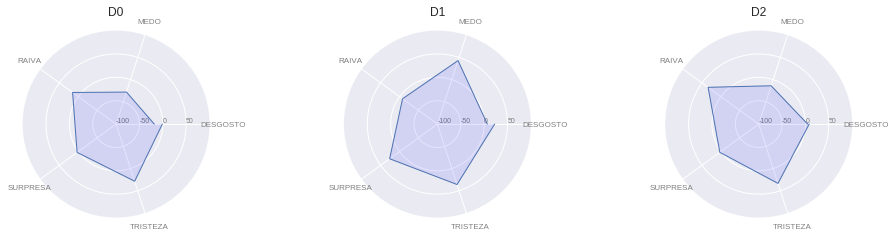

In [263]:
categories = list(df)[1:]
N = len(categories)

# What will be the angle of each axis in the plot? (we divide the plot / number of variable)
angles = [n / float(N) * 2 * np.pi for n in range(N)]
angles += angles[:1]


plt.figure(figsize=(18, 12))
for m in range(3):
    idx = m + 1
    
    values = df.loc[f'D{m}'].values
    print(f'D{m} - {frases_originais[m]}')
    # Initialise the spider plot
    ax = plt.subplot(4, 4, idx, polar=True)
    # Title
    plt.title(f'D{m}')
    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)
    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks(range(-100, 100, 50), [f'{i}' for i in range(-100, 100, 50)], color="grey", size=7)
    plt.ylim(-100, 100)
    # Plot data
    ax.plot(angles, values, linewidth=1, linestyle='solid')
    # Fill area
    ax.fill(angles, values, 'b', alpha=0.1)

plt.tight_layout()
plt.show()

In [264]:
for i, frase in enumerate(frases_originais):
    print('-' * 20)
    print(f'D{i} - {frase}')
    print(df.loc[f'D{i}'])

--------------------
D0 - Deus abençoe o dia de todos você, tenham um bom trabalho e bom estudo a todos. E pra aqueles que não trabalha e nem estuda, boa curtição em sua cama 🙂
ALEGRIA    -18.30
DESGOSTO   -28.03
MEDO        15.03
RAIVA        3.12
SURPRESA    28.58
TRISTEZA    -1.05
Name: D0, dtype: float64
--------------------
D1 - Aprenda a ter amor próprio que nem essa banana que fez uma tatuagem dela mesma.
ALEGRIA      6.86
DESGOSTO    42.82
MEDO        -7.85
RAIVA       26.27
SURPRESA    35.98
TRISTEZA    22.53
Name: D1, dtype: float64
--------------------
D2 - Estou muito feliz hoje
ALEGRIA      4.66
DESGOSTO   -13.84
MEDO        33.80
RAIVA        2.80
SURPRESA    33.48
TRISTEZA     8.04
Name: D2, dtype: float64
--------------------
D3 - Dias chuvosos me deixam triste
ALEGRIA     65.55
DESGOSTO    17.23
MEDO        20.46
RAIVA       -2.95
SURPRESA    28.50
TRISTEZA    26.94
Name: D3, dtype: float64
--------------------
D4 - Hoje o dia esta excelente, eu fico feliz com isso!
AL